In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
from models import *
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
!nvidia-smi | head -19

Populating the interactive namespace from numpy and matplotlib
Sun Nov  5 00:13:58 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 381.22                 Driver Version: 381.22                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 0000:05:00.0      On |                  N/A |
| 26%   46C    P8    18W / 250W |     63MiB / 11171MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 0000:06:00.0     Off |                  N/A |
| 81%   87C    P2   156W / 250W |   5358MiB / 11172MiB |     87%      Default |
+------------------------

In [2]:
class progGAN(tf.keras.models.Model):
    ''''''
    def __init__(self):
        ''''''
        self.G = NVIDIA_generator()
        self.D = NVIDIA_discriminator()
        super(tf.keras.models.Model, self).__init__(
                [i for m in (self.G, self.D) for i in m.inputs],
                [o for m in (self.G, self.D) for o in m.outputs])
        
    def blend(self, step, period=100., n_scales=9):
        ''''''
        scale = tf.range(n_scales, dtype=tf.float32)
        state = tf.minimum(tf.cast(step, tf.float32) / tf.cast(period, tf.float32), n_scales-1)
        return tf.maximum(tf.ones_like(scale) - tf.abs(state - scale), tf.zeros_like(scale))
    
    def grad_penalty(self, xs, xs_hat):
        '''gradient penalty from arxiv.org/pdf/1704.00028.pdf'''
        interps = []
        for i in range(len(xs)):
            alpha = tf.random_uniform(shape=[tf.shape(xs[i])[0],1,1,1])
            interps.append((1-alpha)*xs[i] + alpha*xs_hat[i])
        preds = self.D(interps)
        slopes = []
        for i in interps:
            grads = tf.gradients(preds, i)[0]
            slopes.append(tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3])))
        slopes = tf.stack(slopes, axis=-1)
        return tf.reduce_mean((slopes-1)**2, axis=0)
    
    def train(self, x, batch_size=1, period=100., lambda_GP=10, lr=1e-3, n_critic=1, verbose=True):
        ''''''
        print('Building inputs')
        with tf.variable_scope('Inputs'):
            z = tf.random_normal(shape=(batch_size, 512))
            x = tf.random_crop(x, [batch_size, 1024, 1024, 3])
            #x = tf.random_normal(shape=(batch_size, 1024, 1024, 3))
            xs = [tf.image.resize_bilinear(x, [s, s]) for s in [
                1024, 512, 256, 128, 64, 32, 16, 8, 4]]
            xs_hat = self.G(z)
        
        print('Building losses')
        with tf.variable_scope('Losses'):
            step = tf.Variable(0, name='step')
            blend = self.blend(step, period=period)[::-1] # reverse (hi-res last)
            real = tf.reduce_sum(self.D(xs) * blend)
            fake = tf.reduce_sum(self.D(xs_hat) * blend)
            GP = tf.reduce_sum(self.grad_penalty(xs, xs_hat) * blend)
            L_G = fake
            L_D = real - fake 
            L_D_tot = L_D + lambda_GP*GP 
        
        print('Building optimizers')
        with tf.variable_scope('Optimizers'):
            G_opt = tf.train.AdamOptimizer(lr, beta1=0, beta2=0.99).minimize(
                L_G, var_list=self.G.trainable_weights)
            D_adam = tf.train.AdamOptimizer(lr, beta1=0, beta2=0.99)
            grad_var = D_adam.compute_gradients(L_D_tot, var_list=self.D.trainable_weights)
            D_opt = D_adam.apply_gradients(grad_var, global_step=step)
        
        print('Initializing')
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            dloss, gloss = [], []
            print('Start of training'); time.sleep(1)
            try:
                while 1:
                    for i in tqdm.trange(100, disable=verbose):
                        for _ in range(n_critic):
                            _, ld, gp = sess.run([D_opt, L_D, GP])
                            dloss.append(ld)
                            if verbose: print('L_D: '+str(ld))
                        out = sess.run([G_opt, L_G]+xs_hat)[1:]
                        gloss.append(out[0])
                        imgs = out[1:]
                        if verbose: print('L_G: '+str(out[0]))
            except:
                return dloss, gloss, imgs

In [3]:
pg = progGAN()
print('Gen params ~ {:0.1e}\nDisc params ~ {:0.1e}'.format(
    pg.G.count_params(), pg.D.count_params()))

Gen params ~ 2.3e+07
Disc params ~ 2.3e+07


/data/datasets/Hi_res_stills/Cosmic/Cosmic_014.jpg


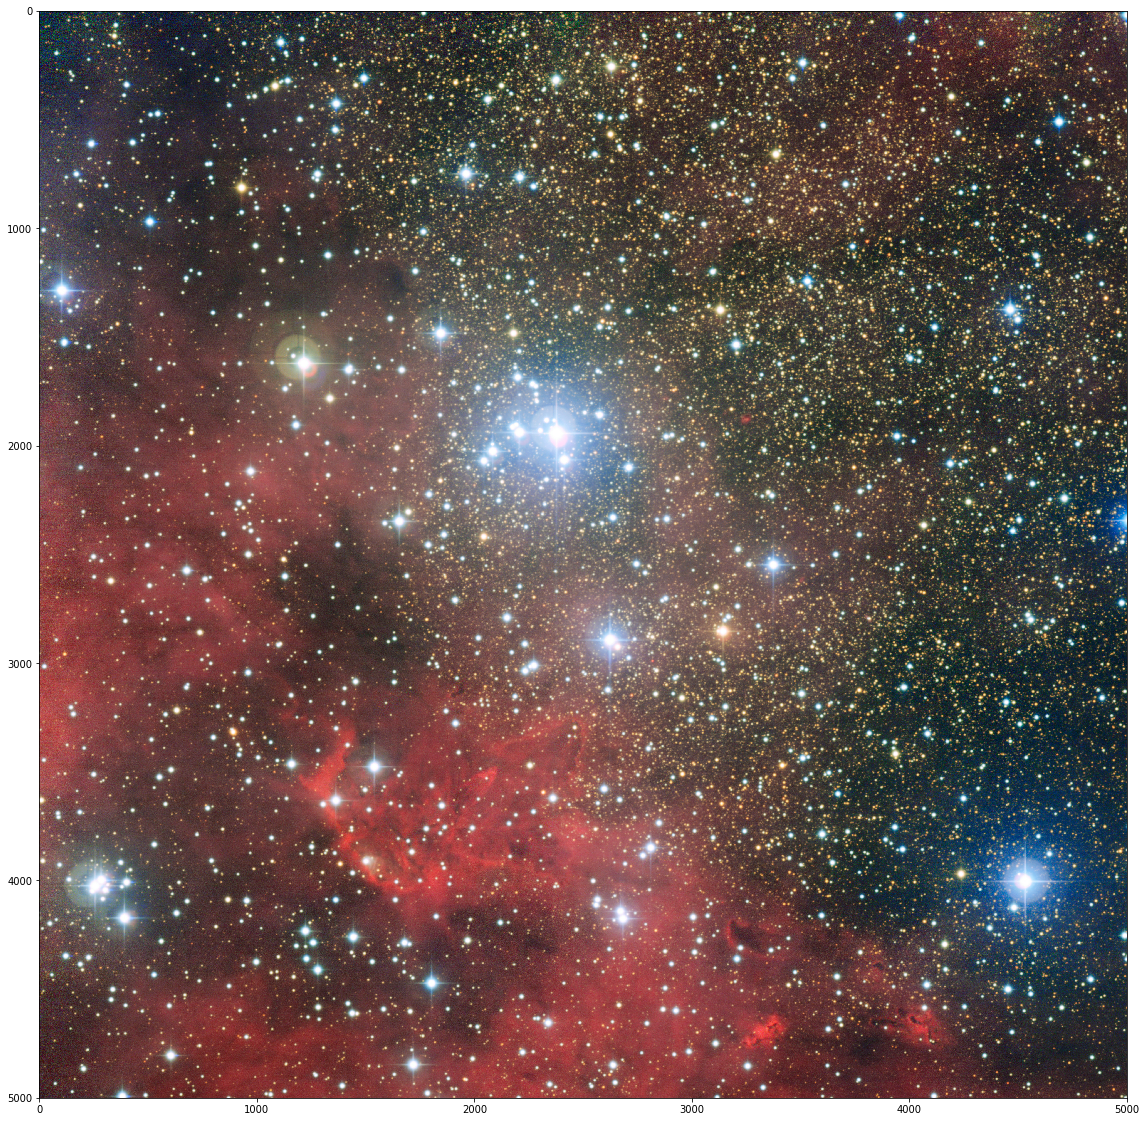

In [ ]:
x = []
for imagefile in glob.glob('/data/datasets/Hi_res_stills/Cosmic/*')[2:3]:
    print(imagefile)
    x += [imread(imagefile)[:5000, :5000]]
x = stack(x, 0)
figure(figsize=(20, 20))
imshow(x[-1], aspect='equal')
x = x.astype(float)
x /= 127.5
x -= 1

In [ ]:
dloss, gloss, imgs = pg.train(x, batch_size=1, period=10000, lambda_GP=10, lr=1e-3, n_critic=1, verbose=False)

Building inputs
Building losses
Building optimizers
Initializing
Start of training


 63%|██████▎   | 63/100 [02:09<01:16,  2.06s/it]

In [ ]:
imshow((imgs[-1][0]*127.5 + 127.5).astype('uint8'), aspect='equal')

In [ ]:
semilogy(dloss)